# water masses during transition periods

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# spring transition (downwelling to upwelling)
spri = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/20220611/ariane_positions_quantitative.nc")

# fall transition (upwelling to downwelling)
fall = xr.open_dataset("/data1/bbeutel/LO_user/ariane/buffer_cas7/20181024/ariane_positions_quantitative.nc")

In [17]:
def wm_day_divide(mydata):
    start = 2401
    length =int((np.max(mydata.init_t)-start+1)/24)

    bdy_loo = 0
    bdy_sou = 2
    bdy_off = 3
    bdy_nor = 4

    saltdiv = 32
    sdiv = 33.5

    total = [np.sum(mydata.final_transp[((abs(mydata.init_t-mydata.final_t) > 24) & ~np.isnan(mydata.final_section)) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    fresh = [np.sum(mydata.final_transp[(mydata.final_section==bdy_sou) & (mydata.final_salt < saltdiv) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    cuc = [np.sum(mydata.final_transp[(mydata.final_section==bdy_sou) & (mydata.final_salt >= sdiv) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    south = [np.sum(mydata.final_transp[(mydata.final_section==bdy_sou) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)  & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    north = [np.sum(mydata.final_transp[(mydata.final_section==bdy_nor) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    offshore_d = [np.sum(mydata.final_transp[(mydata.final_section==bdy_off) & (mydata.final_depth > 120) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    offshore_s = [np.sum(mydata.final_transp[(mydata.final_section==bdy_off) & (mydata.final_depth <=120) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    
    loop = [np.sum(mydata.final_transp[(mydata.final_section==bdy_loo) & (abs(mydata.init_t-mydata.final_t) > 24) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
 
    return total, fresh, cuc, south, north, offshore_d, offshore_s, loop


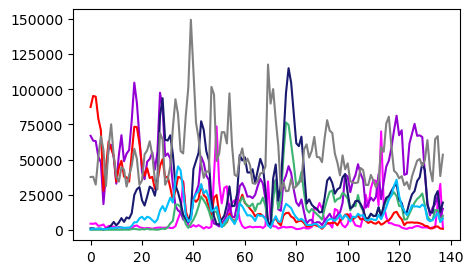

In [20]:
fig,ax = plt.subplots(1,1,figsize=(5,3))

# spring first
total, fresh, cuc, south, north, off_d, off_s, loop =wm_day_divide(spri)
# ax.plot(total,'k--')
ax.plot(fresh,color='magenta')
ax.plot(cuc,color='darkviolet')
ax.plot(south,color='red')
ax.plot(north,color='mediumseagreen')
ax.plot(off_d,color='midnightblue')
ax.plot(off_s,color='deepskyblue')
ax.plot(loop,color='grey')

what we see: inconsistent dominant WM. In the beginning of the transition CUC and south dominant (makes sense bc going from downwelling... may be argument for 15 longer season) <br>
20 days in offshore deep water becomes important, but still big peaks in fresh water throughout the time period <br>
south water contribution seems to gradually decrease throughout 

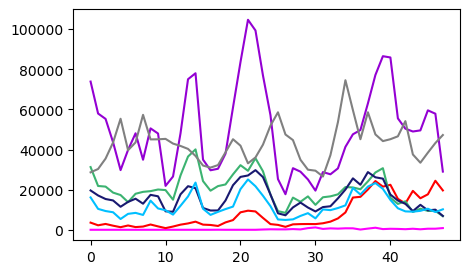

In [22]:
fig,ax = plt.subplots(1,1,figsize=(5,3))

# fall
total, fresh, cuc, south, north, off_d, off_s, loop =wm_day_divide(fall)
# ax.plot(total,'k--')
ax.plot(fresh,color='magenta')
ax.plot(cuc,color='darkviolet')
ax.plot(south,color='red')
ax.plot(north,color='mediumseagreen')
ax.plot(off_d,color='midnightblue')
ax.plot(off_s,color='deepskyblue')
ax.plot(loop,color='grey')

what we see: pretty consistent ordering of water masses cuc>north>offshore deep>offshore surface>south (until the end when south begins to increase) and fresh almost nonexistent <br>
this all appears more like an upwelling period than a transition

In [4]:
def means(df):
    # make dictionary of mean transport and tracer concentrations of each WM and of JdF inflow

    # set data dictionary
    # for each variable, saved in the order total -> loop -> fresh -> south -> cuc -> off_d -> off_s -> north
    d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
        'transport':np.zeros(8),'salt':np.zeros(8),'temp':np.zeros(8)}
    data = pd.DataFrame(d)

    # hours over which data was integrated
    start = 2401
    length =(np.max(df.init_t)-start+1)

    # boundary definitions
    bdy_loo = 0
    bdy_sou = 2
    bdy_off = 3
    bdy_nor = 4

    saltdiv = 32
    sdiv = 33.5

    
    # total
    dfbool = ((abs(df.init_t-df.final_t) > 24) & ~np.isnan(df.final_section)) # total.. but not including tidal pumping or lost particles
    transport = df.init_transp[dfbool].values
    data.loc[0,'transport'] = np.sum(transport)/(length)
    data.loc[0,'salt'] = np.average(df.init_salt[dfbool], weights = transport)
    data.loc[0,'temp'] = np.average(df.init_temp[dfbool], weights = transport)

    # loop
    dfbool = (df.final_section==bdy_loo) & (abs(df.init_t-df.final_t) > 24)
    transport = df.init_transp[dfbool].values
    data.loc[7,'transport'] = np.sum(transport)/(length)
    data.loc[7,'salt'] = np.average(df.init_salt[dfbool], weights = transport)
    data.loc[7,'temp'] = np.average(df.init_temp[dfbool], weights = transport)

    # fresh
    dfbool = ((df.final_section==bdy_sou) & (df.final_salt < saltdiv))
    transport = df.init_transp[dfbool].values
    data.loc[6,'transport'] = np.sum(transport)/(length)
    data.loc[6,'salt'] = np.average(df.init_salt[dfbool], weights = transport)
    data.loc[6,'temp'] = np.average(df.init_temp[dfbool], weights = transport)

    # south
    dfbool = (df.final_section==bdy_sou) & (df.final_salt >= saltdiv) & (df.final_salt < sdiv)
    transport = df.init_transp[dfbool].values
    data.loc[5,'transport'] = np.sum(transport)/(length)
    data.loc[5,'salt'] = np.average(df.init_salt[dfbool], weights = transport)
    data.loc[5,'temp'] = np.average(df.init_temp[dfbool], weights = transport)

    # cuc
    dfbool = (df.final_section==bdy_sou) & (df.final_salt >= sdiv)
    transport = df.init_transp[dfbool].values
    data.loc[1,'transport'] = np.sum(transport)/(length)
    data.loc[1,'salt'] = np.average(df.init_salt[dfbool], weights = transport)
    data.loc[1,'temp'] = np.average(df.init_temp[dfbool], weights = transport)

    # off_d
    dfbool = (df.final_section==bdy_off) & (df.final_depth > 120)
    transport = df.init_transp[dfbool].values
    data.loc[2,'transport'] = np.sum(transport)/(length)
    data.loc[2,'salt'] = np.average(df.init_salt[dfbool], weights = transport)
    data.loc[2,'temp'] = np.average(df.init_temp[dfbool], weights = transport)

    # off_s
    dfbool = (df.final_section==bdy_off) & (df.final_depth <=120)
    transport = df.init_transp[dfbool].values
    data.loc[3,'transport'] = np.sum(transport)/(length)
    data.loc[3,'salt'] = np.average(df.init_salt[dfbool], weights = transport)
    data.loc[3,'temp'] = np.average(df.init_temp[dfbool], weights = transport)

    # north
    dfbool = (df.final_section==bdy_nor)
    transport = df.init_transp[dfbool].values
    data.loc[4,'transport'] = np.sum(transport)/(length)
    data.loc[4,'salt'] = np.average(df.init_salt[dfbool], weights = transport)
    data.loc[4,'temp'] = np.average(df.init_temp[dfbool], weights = transport)

    return data

In [5]:
spri_df = means(spri)
spri_df

,section,transport,salt,temp
0,salish,166426.990381,33.006645,7.222166
1,cuc,33871.788492,33.472854,7.019214
2,off_d,28669.353734,33.446994,6.939588
3,off_s,10866.590254,33.207204,7.068367
4,north,13874.629427,33.352260,6.943298
5,south,19219.872036,33.213044,7.384109
6,fresh,7666.599869,30.511156,8.546078
7,loop,52258.156569,32.619614,7.360971


In [6]:
fall_df = means(fall)
fall_df

,section,transport,salt,temp
0,salish,149944.928572,33.421365,7.443459
1,cuc,50198.471980,33.548579,7.220439
2,off_d,16207.995227,33.506059,7.294782
3,off_s,12184.285614,33.469262,7.383638
4,north,20251.860451,33.472811,7.366644
5,south,7715.489740,33.452073,7.451363
6,fresh,263.584549,33.208550,7.996098
7,loop,43123.241012,33.199561,7.807134


In [8]:
# from quant_attribution.ipynb..

# mean dw:
# salish = 150853, cuc = 22058, off_d = 4641, off_s = 4393, north = 2106, south = 33278, fresh = 25035, loop = 59339

# mean up:
# salish = 180470, cuc = 44318, off_d = 39670, off_s = 8261, north = 35373, south = 6593, fresh = 1697, loop = 44555, 